In [2]:
using PhyloPlots
using PhyloNetworks
using PhyloCoalSimulations
using Combinatorics
using Formatting
using Distributions
using Random
using CSV, DataFrames
using JLD
using SparseArrays

trees = readMultiTopology("../../../data/rawdata/4taxa_trees.tre");

In [2]:
trees[1]

HybridNetwork, Rooted Network
6 edges
7 nodes: 4 tips, 0 hybrid nodes, 3 internal tree nodes.
tip labels: 4, 3, 1, 2
(4:3.866,(3:1.593,(1:1.208,2:1.208):0.386):2.273);


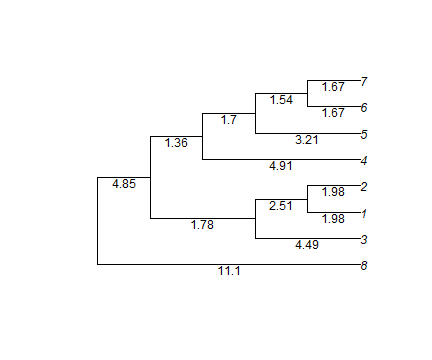

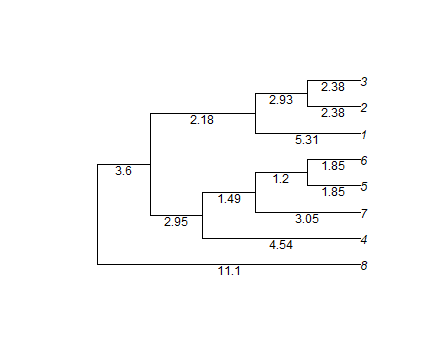

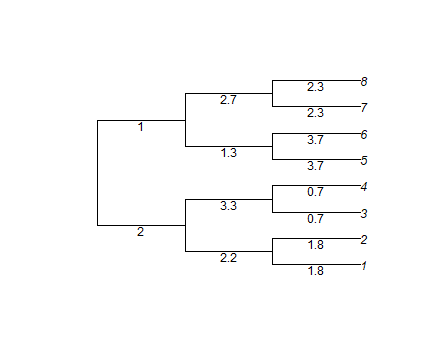

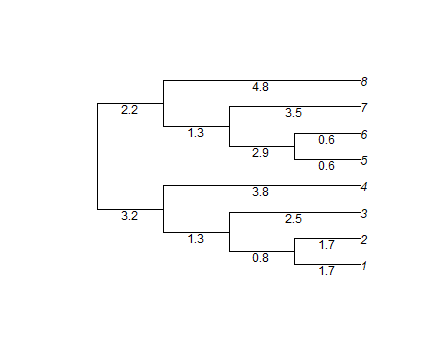

In [3]:
tree_1 = readTopology("(8:11.118,((3:4.485,(1:1.976,2:1.976):2.509):1.783,(4:4.911,(5:3.208,(6:1.666,7:1.666):1.541):1.704):1.357):4.850);");
tree_2 = readTopology("(8:11.087,((4:4.537,(7:3.051,(5:1.855,6:1.855):1.196):1.486):2.953,(1:5.314,(2:2.383,3:2.383):2.931):2.176):3.597);");
tree_3 = readTopology("(((1:1.8,2:1.8):2.2,(3:0.7,4:0.7):3.3):2,((5:3.7,6:3.7):1.3,(7:2.3,8:2.3):2.7):1);");
tree_4 = readTopology("(((((1:1.7,2:1.7):0.8,3:2.5):1.3,4:3.8):3.2,(((5:0.6,6:0.6):2.9,7:3.5):1.3,8:4.8):2.2));");
plot(tree_1, :R, showEdgeLength=true);
plot(tree_2, :R, showEdgeLength=true);
plot(tree_3, :R, showEdgeLength=true);
plot(tree_4, :R, showEdgeLength=true);

In [4]:
trees_1 = simulatecoalescent(tree_1, 100, 1);
trees_2 = simulatecoalescent(tree_2, 100, 1);
trees_3 = simulatecoalescent(tree_3, 100, 1);
trees_4 = simulatecoalescent(tree_4, 100, 1);
writeMultiTopology(trees_1, "./data/rawdata/8_taxa_1.trees")
writeMultiTopology(trees_2, "./data/rawdata/8_taxa_2.trees")
writeMultiTopology(trees_3, "./data/rawdata/8_taxa_3.trees")
writeMultiTopology(trees_4, "./data/rawdata/8_taxa_4.trees")

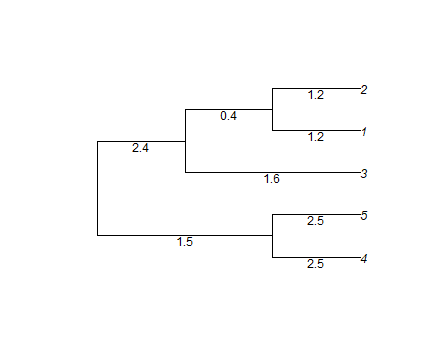

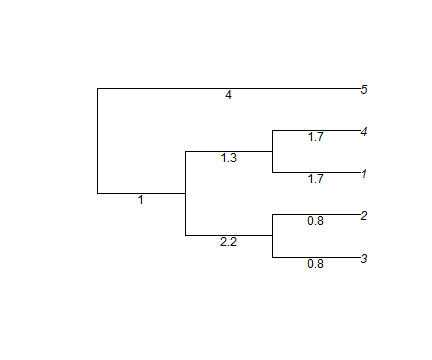

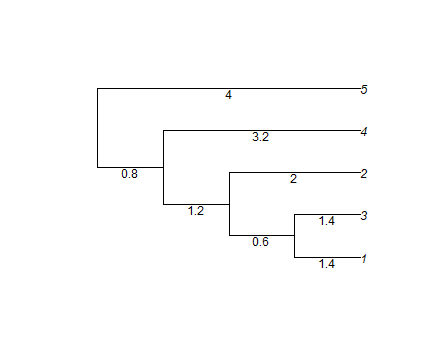

In [5]:
tree_1 = readTopology("((4:2.5,5:2.5):1.5,(3:1.6,(1:1.2,2:1.2):0.4):2.4);");
tree_2 = readTopology("(((3:0.8,2:0.8):2.2,(1:1.7, 4:1.7):1.3):1,5:4);");
tree_3 = readTopology("((((1:1.4,3:1.4):0.6,2:2):1.2,4:3.2):0.8,5:4);");
plot(tree_1, :R, showEdgeLength=true);
plot(tree_2, :R, showEdgeLength=true);
plot(tree_3, :R, showEdgeLength=true);

In [6]:
trees_1 = simulatecoalescent(tree_1, 100, 1);
trees_2 = simulatecoalescent(tree_2, 100, 1);
trees_3 = simulatecoalescent(tree_3, 100, 1);
writeMultiTopology(trees_1, "./data/rawdata/5_taxa_1.trees")
writeMultiTopology(trees_2, "./data/rawdata/5_taxa_2.trees")
writeMultiTopology(trees_3, "./data/rawdata/5_taxa_3.trees")

In [3]:
# simulate 4-taxa trees

function num_bipartitions(n)
    return 2^(n-1) - 1
end;

function get_nodes(idx)
    nodes = []
    for i in 1:length(idx)
        if idx[i]
            append!(nodes, i)
        end
    end
    return nodes
end


function get_bipartition(tree, n)
    taxa = sort(tipLabels(tree))
    if length(taxa) != n
        print("check the parameter n")
        return
    end
    node = Vector(1:n)
    result = []
    idx = 0
    for i in tree.edge
        node_idx = hardwiredCluster(i,taxa)
        branch_node = get_nodes(node_idx)
        
        # if branch seperates more than half nodes, we use the small part to get bipartition idx
        if (length(branch_node) > n ÷ 2)
             branch_node = sort(collect(setdiff(node,branch_node)))
        end
        
        # generate all possible combination with the same number of nodes
        comb = collect(combinations(Vector(1:n), length(branch_node)))
        for c in 1:length(comb)
            if comb[c] == branch_node
                # if the combination is the later, we need to find its first half
                if length(branch_node) > 1 && c > length(comb) ÷ 2
                    c = length(comb) - c + 1 
                end
                idx = c - 1
                break
            end
        end
        for j in 1:(length(branch_node) - 1)
            idx = idx + binomial(n,j)
        end
        push!(result,Pair(idx, i.length))
        idx = 0
    end
    return result
end;

function print_bipartition(trees, n)
    
    # build the table
    N = num_bipartitions(n)
    data = zeros(length(trees), N)
    treeNum = 1;
    # get existing index
    
    for i in trees
        bipart = get_bipartition(i, n)
        for j in 1:length(bipart)
            data[treeNum,(bipart[j][1] + 1)] += bipart[j][2]
        end
        treeNum+=1
    end
    return data
end;

function print_csv(path, n, target)
    tree = readMultiTopology(path)
    result = print_bipartition(tree, n)
    N = num_bipartitions(n)
    header = Vector(0:N - 1)
    header = string.(header)
    CSV.write(target, DataFrame(result, :auto),header = header) 
end;

In [2]:
# 8-taxa trees
case1 = "((1:0.0,6:0.0):0.0,(((2:0.0,5:0.0):0.0,((4:0.0,3:0.0):0.0,8:0.0):0.0):0.0,7:0.0):0.0);"
case2 = "((1:0.0,(2:0.0,4:0.0):0.0):0.0,(((6:0.0,3:0.0):0.0,7:0.0):0.0,(5:0.0,8:0.0):0.0):0.0);"
case3 = "((((5:0.0,6:0.0):0.0,2:0.0):0.0,((1:0.0,3:0.0):0.0,(7:0.0,8:0.0):0.0):0.0):0.0,4:0.0);"
case4 = "(6:0.0,((1:0.0,7:0.0):0.0,(2:0.0,((4:0.0,8:0.0):0.0,(3:0.0,5:0.0):0.0):0.0):0.0):0.0);"
case5 = "(3:0.0,((5:0.0,((1:0.0,4:0.0):0.0,6:0.0):0.0):0.0,((8:0.0,7:0.0):0.0,2:0.0):0.0):0.0);"
case6 = "((((1:0.0,7:0.0):0.0,2:0.0):0.0,((8:0.0,6:0.0):0.0,(5:0.0,3:0.0):0.0):0.0):0.0,4:0.0);"
case7 = "((1:0.0,(((6:0.0,2:0.0):0.0,3:0.0):0.0,4:0.0):0.0):0.0,(5:0.0,(8:0.0,7:0.0):0.0):0.0);"
case8 = "((1:0.0,2:0.0):0.0,(((7:0.0,6:0.0):0.0,((3:0.0,4:0.0):0.0,8:0.0):0.0):0.0,5:0.0):0.0);"
case9 = "((((6:0.0,7:0.0):0.0,(4:0.0,2:0.0):0.0):0.0,(8:0.0,(5:0.0,3:0.0):0.0):0.0):0.0,1:0.0);"
case10 = "(((6:0.0,3:0.0):0.0,((7:0.0,1:0.0):0.0,8:0.0):0.0):0.0,((5:0.0,4:0.0):0.0,2:0.0):0.0);"
case11 = "(((((8:0.0,7:0.0):0.0,5:0.0):0.0,(3:0.0,(1:0.0,6:0.0):0.0):0.0):0.0,4:0.0):0.0,2:0.0);"
case12 = "((7:0.0,((4:0.0,8:0.0):0.0,6:0.0):0.0):0.0,(3:0.0,((2:0.0,1:0.0):0.0,5:0.0):0.0):0.0);"
case13 = "(((1:0.0,3:0.0):0.0,6:0.0):0.0,((7:0.0,(8:0.0,4:0.0):0.0):0.0,(5:0.0,2:0.0):0.0):0.0);"
case14 = "(((6:0.0,4:0.0):0.0,3:0.0):0.0,(7:0.0,(2:0.0,(5:0.0,(1:0.0,8:0.0):0.0):0.0):0.0):0.0);"
case15 = "((4:0.0,6:0.0):0.0,(((8:0.0,(1:0.0,7:0.0):0.0):0.0,3:0.0):0.0,(5:0.0,2:0.0):0.0):0.0);"

"((4:0.0,6:0.0):0.0,(((8:0.0,(1:0.0,7:0.0):0.0):0.0,3:0.0):0.0,(5:0.0,2:0.0):0.0):0.0);"

In [3]:
trees_string = [case1,case2,case3,case4,case5,case6,case7,case8,case9,case10,case11,case12,case13,case14,case15];

In [6]:
d = Uniform(0.5, 2)
for i in 1:100
    for j in 1:length(trees_string)
        tree = readTopology(trees_string[j])
        Random.seed!((123+i)*j)
        n = length(tree.edge)

        x = rand(d, n)
        idx = 1
        for e in tree.edge
            e.length += x[idx]
            e.length = round(e.length, digits = 2)
            idx += 1
        end
        
        tree = simulatecoalescent(tree, 50, 1)
        tree = print_bipartition(tree, 8)
        tree = sparse(tree)
        target = "data/8_diff_topo_" * string(j) *  "_50_" * string(i) * ".jld"
        jldopen(target, "w") do file
            write(file, "tree", tree)
        end
    end
end;

In [ ]:
d = Uniform(0.5, 2)
Threads.@threads for i in 1:100
    for j in 1:length(trees_string)
        tree = readTopology(trees_string[j])
        Random.seed!((123+i)*j)
        n = length(tree.edge)

        x = rand(d, n)
        idx = 1
        for e in tree.edge
            e.length += x[idx]
            e.length = round(e.length, digits = 2)
            idx += 1
        end
        
        tree = simulatecoalescent(tree, 100, 1)
        tree = print_bipartition(tree, 8)
        tree = sparse(tree)
        target = "data/8_diff_topo_" * string(j) *  "_100_" * string(i) * ".jld"
        jldopen(target, "w") do file
            write(file, "tree", tree)
        end
    end
end;

In [ ]:
d = Uniform(0.5, 2)
Threads.@threads for i in 1:100
    for j in 1:length(trees_string)
        tree = readTopology(trees_string[j])
        Random.seed!((123+i)*j)
        n = length(tree.edge)

        x = rand(d, n)
        idx = 1
        for e in tree.edge
            e.length += x[idx]
            e.length = round(e.length, digits = 2)
            idx += 1
        end
        
        tree = simulatecoalescent(tree, 500, 1)
        tree = print_bipartition(tree, 8)
        tree = sparse(tree)
        target = "data/8_diff_topo_" * string(j) *  "_500_" * string(i) * ".jld"
        jldopen(target, "w") do file
            write(file, "tree", tree)
        end
    end
end;

In [ ]:
d = Uniform(0.5, 2)
Threads.@threads for i in 1:100
    for j in 1:length(trees_string)
        tree = readTopology(trees_string[j])
        Random.seed!((123+i)*j)
        n = length(tree.edge)

        x = rand(d, n)
        idx = 1
        for e in tree.edge
            e.length += x[idx]
            e.length = round(e.length, digits = 2)
            idx += 1
        end
        
        tree = simulatecoalescent(tree, 1000, 1)
        tree = print_bipartition(tree, 8)
        tree = sparse(tree)
        target = "data/8_diff_topo_" * string(j) *  "_1000_" * string(i) * ".jld"
        jldopen(target, "w") do file
            write(file, "tree", tree)
        end
    end
end;

In [ ]:
d = Uniform(0.5, 2)
Threads.@threads for i in 1:100
    for j in 1:length(trees_string)
        tree = readTopology(trees_string[j])
        Random.seed!((123+i)*j)
        n = length(tree.edge)

        x = rand(d, n)
        idx = 1
        for e in tree.edge
            e.length += x[idx]
            e.length = round(e.length, digits = 2)
            idx += 1
        end
        
        tree = simulatecoalescent(tree, 5000, 1)
        tree = print_bipartition(tree, 8)
        tree = sparse(tree)
        target = "data/8_diff_topo_" * string(j) *  "_5000_" * string(i) * ".jld"
        jldopen(target, "w") do file
            write(file, "tree", tree)
        end
    end
end;

In [ ]:
d = Uniform(0.5, 2)
Threads.@threads for i in 1:100
    for j in 1:length(trees_string)
        tree = readTopology(trees_string[j])
        Random.seed!((123+i)*j)
        n = length(tree.edge)

        x = rand(d, n)
        idx = 1
        for e in tree.edge
            e.length += x[idx]
            e.length = round(e.length, digits = 2)
            idx += 1
        end
        
        tree = simulatecoalescent(tree, 10000, 1)
        tree = print_bipartition(tree, 8)
        tree = sparse(tree)
        target = "data/8_diff_topo_" * string(j) *  "_10000_" * string(i) * ".jld"
        jldopen(target, "w") do file
            write(file, "tree", tree)
        end
    end
end;

In [7]:
# different topologies with randomly chosen branch lengths Uniform (0.5, 2.0)

'''
No longer used 
d = Uniform(0.5, 2)
for i in 1:100
    for j in 1:length(trees_string)
        tree = readTopology(trees_string[j])
        Random.seed!((123+i)*j)
        n = length(tree.edge)

        x = rand(d, n)
        idx = 1
        for e in tree.edge
            e.length += x[idx]
            e.length = round(e.length, digits = 2)
            idx += 1
        end
        
        tree = simulatecoalescent(tree, 1000, 1);        
        path = "./data/rawdata/8_diff_topo_" * string(j) *  "_1000_" * string(i) * ".trees" 
        writeMultiTopology(tree, path)
        target = "data/8_diff_topo_" * string(j) *  "_1000_" * string(i) * ".csv"
        print_csv(path, 8, target);
    end
end

d = Uniform(0.5, 2)
for i in 1:100
    for j in 1:length(trees_string)
        tree = readTopology(trees_string[j])
        Random.seed!((123+i)*j)
        n = length(tree.edge)

        x = rand(d, n)
        idx = 1
        for e in tree.edge
            e.length += x[idx]
            e.length = round(e.length, digits = 2)
            idx += 1
        end
        
        tree = simulatecoalescent(tree, 5000, 1);        
        path = "./data/rawdata/8_diff_topo_" * string(j) *  "_5000_" * string(i) * ".trees" 
        writeMultiTopology(tree, path)
        target = "data/8_diff_topo_" * string(j) *  "_5000_" * string(i) * ".csv"
        print_csv(path, 8, target);
    end
end

d = Uniform(0.5, 2)
for i in 1:100
    for j in 1:length(trees_string)
        tree = readTopology(trees_string[j])
        Random.seed!((123+i)*j)
        n = length(tree.edge)

        x = rand(d, n)
        idx = 1
        for e in tree.edge
            e.length += x[idx]
            e.length = round(e.length, digits = 2)
            idx += 1
        end
        
        tree = simulatecoalescent(tree, 10000, 1);        
        path = "./data/rawdata/8_diff_topo_" * string(j) *  "_10000_" * string(i) * ".trees" 
        writeMultiTopology(tree, path)
        target = "data/8_diff_topo_" * string(j) *  "_10000_" * string(i) * ".csv"
        print_csv(path, 8, target);
    end
end
'''

In [3]:
# 16-taxa trees
case1 = "((6:0.0,(10:0.0,7:0.0):0.0):0.0,(((4:0.0,14:0.0):0.0,(((11:0.0,(8:0.0,13:0.0):0.0):0.0,(12:0.0,(5:0.0,(3:0.0,15:0.0):0.0):0.0):0.0):0.0,(1:0.0,(2:0.0,9:0.0):0.0):0.0):0.0):0.0,16:0.0):0.0);"
case2 = "(((10:0.0,(8:0.0,1:0.0):0.0):0.0,((12:0.0,11:0.0):0.0,(2:0.0,5:0.0):0.0):0.0):0.0,((3:0.0,(((14:0.0,16:0.0):0.0,(15:0.0,4:0.0):0.0):0.0,6:0.0):0.0):0.0,((9:0.0,7:0.0):0.0,13:0.0):0.0):0.0);"
case3 = "((9:0.0,((15:0.0,(((16:0.0,(8:0.0,12:0.0):0.0):0.0,(4:0.0,2:0.0):0.0):0.0,3:0.0):0.0):0.0,(((6:0.0,(1:0.0,7:0.0):0.0):0.0,10:0.0):0.0,13:0.0):0.0):0.0):0.0,(5:0.0,(11:0.0,14:0.0):0.0):0.0);"
case4 = "(((7:0.0,16:0.0):0.0,((((9:0.0,6:0.0):0.0,3:0.0):0.0,(11:0.0,14:0.0):0.0):0.0,(2:0.0,(13:0.0,(10:0.0,4:0.0):0.0):0.0):0.0):0.0):0.0,(((12:0.0,8:0.0):0.0,5:0.0):0.0,(1:0.0,15:0.0):0.0):0.0);"
case5 = "((11:0.0,1:0.0):0.0,((((12:0.0,2:0.0):0.0,7:0.0):0.0,10:0.0):0.0,(((3:0.0,(15:0.0,(13:0.0,9:0.0):0.0):0.0):0.0,(16:0.0,(14:0.0,(5:0.0,4:0.0):0.0):0.0):0.0):0.0,(6:0.0,8:0.0):0.0):0.0):0.0);"
case6 = "(((8:0.0,4:0.0):0.0,((3:0.0,12:0.0):0.0,10:0.0):0.0):0.0,(((((16:0.0,((2:0.0,5:0.0):0.0,13:0.0):0.0):0.0,14:0.0):0.0,1:0.0):0.0,15:0.0):0.0,((11:0.0,(9:0.0,6:0.0):0.0):0.0,7:0.0):0.0):0.0);"
case7 = "(((10:0.0,15:0.0):0.0,(((6:0.0,14:0.0):0.0,5:0.0):0.0,(((7:0.0,3:0.0):0.0,11:0.0):0.0,4:0.0):0.0):0.0):0.0,(((13:0.0,9:0.0):0.0,(1:0.0,(16:0.0,2:0.0):0.0):0.0):0.0,(8:0.0,12:0.0):0.0):0.0);"
case8 = "((((1:0.0,6:0.0):0.0,3:0.0):0.0,(7:0.0,(((8:0.0,(4:0.0,16:0.0):0.0):0.0,13:0.0):0.0,14:0.0):0.0):0.0):0.0,((((9:0.0,11:0.0):0.0,2:0.0):0.0,(15:0.0,5:0.0):0.0):0.0,(10:0.0,12:0.0):0.0):0.0);"
case9 = "((3:0.0,(5:0.0,2:0.0):0.0):0.0,(((8:0.0,(13:0.0,9:0.0):0.0):0.0,16:0.0):0.0,((((6:0.0,10:0.0):0.0,(11:0.0,15:0.0):0.0):0.0,((12:0.0,4:0.0):0.0,1:0.0):0.0):0.0,(7:0.0,14:0.0):0.0):0.0):0.0);"
case10 = "(((8:0.0,12:0.0):0.0,(((1:0.0,4:0.0):0.0,(10:0.0,((16:0.0,14:0.0):0.0,6:0.0):0.0):0.0):0.0,(3:0.0,9:0.0):0.0):0.0):0.0,(((5:0.0,2:0.0):0.0,(15:0.0,11:0.0):0.0):0.0,(7:0.0,13:0.0):0.0):0.0);"
case11 = "((11:0.0,(13:0.0,4:0.0):0.0):0.0,((1:0.0,((14:0.0,(9:0.0,8:0.0):0.0):0.0,(((3:0.0,12:0.0):0.0,7:0.0):0.0,10:0.0):0.0):0.0):0.0,((15:0.0,2:0.0):0.0,((6:0.0,16:0.0):0.0,5:0.0):0.0):0.0):0.0);"
case12 = "(((((12:0.0,7:0.0):0.0,3:0.0):0.0,(9:0.0,1:0.0):0.0):0.0,14:0.0):0.0,((15:0.0,((((8:0.0,6:0.0):0.0,(16:0.0,2:0.0):0.0):0.0,(5:0.0,4:0.0):0.0):0.0,13:0.0):0.0):0.0,(11:0.0,10:0.0):0.0):0.0);"
case13 = "((8:0.0,(7:0.0,(15:0.0,13:0.0):0.0):0.0):0.0,((((16:0.0,10:0.0):0.0,(14:0.0,1:0.0):0.0):0.0,11:0.0):0.0,(((12:0.0,((3:0.0,5:0.0):0.0,9:0.0):0.0):0.0,(2:0.0,4:0.0):0.0):0.0,6:0.0):0.0):0.0);"
case14 = "((((2:0.0,((3:0.0,10:0.0):0.0,4:0.0):0.0):0.0,13:0.0):0.0,((11:0.0,5:0.0):0.0,((6:0.0,8:0.0):0.0,((12:0.0,16:0.0):0.0,14:0.0):0.0):0.0):0.0):0.0,((9:0.0,1:0.0):0.0,(15:0.0,7:0.0):0.0):0.0);"
case15 = "((((13:0.0,((10:0.0,3:0.0):0.0,(12:0.0,(5:0.0,16:0.0):0.0):0.0):0.0):0.0,8:0.0):0.0,((1:0.0,((9:0.0,15:0.0):0.0,2:0.0):0.0):0.0,7:0.0):0.0):0.0,((14:0.0,4:0.0):0.0,(11:0.0,6:0.0):0.0):0.0);"

"((((13:0.0,((10:0.0,3:0.0):0.0,(12:0.0,(5:0.0,16:0.0):0.0):0.0):0.0):0.0,8:0.0):0.0,((1:0.0,((9:0.0,15:0.0):0.0,2:0.0):0.0):0.0,7:0.0):0.0):0.0,((14:0.0,4:0.0):0.0,(11:0.0,6:0.0):0.0):0.0);"

In [4]:
trees_string = [case1,case2,case3,case4,case5,case6,case7,case8,case9,case10,case11,case12,case13,case14,case15];

In [9]:
tree = readTopology(trees_string[1])
tree = simulatecoalescent(tree, 100, 1)
tree = print_bipartition(tree, 16)
tree = sparse(tree)

100×32767 SparseMatrixCSC{Float64, Int64} with 2884 stored entries:
⠛⠛⠃⠛⠛⠛⠀⠀⠘⠛⠛⠛⠛⠃⠀⠀⠀⠀⠋⠓⠛⠛⠛⠛⠛⠁⠀⠀⠀⠀⠀⠀⠓⠛⠙⠓⠙⠑⠒⠃

In [10]:
# different topologies with randomly chosen branch lengths Uniform (0.5, 2.0)
d = Uniform(0.5, 2)
Threads.@threads for i in 1:100
    for j in 1:length(trees_string)
        tree = readTopology(trees_string[j])
        Random.seed!((123+i)*j)
        n = length(tree.edge)

        x = rand(d, n)
        idx = 1
        for e in tree.edge
            e.length += x[idx]
            e.length = round(e.length, digits = 2)
            idx += 1
        end
        
        tree = simulatecoalescent(tree, 50, 1)
        tree = print_bipartition(tree, 16)
        tree = sparse(tree)
        target = "data/16_diff_topo_" * string(j) *  "_50_" * string(i) * ".jld"
        jldopen(target, "w") do file
            write(file, "tree", tree)
        end
    end
end;


In [ ]:
d = Uniform(0.5, 2)
Threads.@threads for i in 1:100
    for j in 1:length(trees_string)
        tree = readTopology(trees_string[j])
        Random.seed!((123+i)*j)
        n = length(tree.edge)

        x = rand(d, n)
        idx = 1
        for e in tree.edge
            e.length += x[idx]
            e.length = round(e.length, digits = 2)
            idx += 1
        end
        
        tree = simulatecoalescent(tree, 100, 1)
        tree = print_bipartition(tree, 16)
        tree = sparse(tree)
        target = "data/16_diff_topo_" * string(j) *  "_100_" * string(i) * ".jld"
        jldopen(target, "w") do file
            write(file, "tree", tree)
        end
    end
end;

In [ ]:
d = Uniform(0.5, 2)
Threads.@threads for i in 1:100
    for j in 1:length(trees_string)
        tree = readTopology(trees_string[j])
        Random.seed!((123+i)*j)
        n = length(tree.edge)

        x = rand(d, n)
        idx = 1
        for e in tree.edge
            e.length += x[idx]
            e.length = round(e.length, digits = 2)
            idx += 1
        end
        
        tree = simulatecoalescent(tree, 500, 1)
        tree = print_bipartition(tree, 16)
        tree = sparse(tree)
        target = "data/16_diff_topo_" * string(j) *  "_500_" * string(i) * ".jld"
        jldopen(target, "w") do file
            write(file, "tree", tree)
        end
    end
end;

In [ ]:
# different topologies with randomly chosen branch lengths Uniform (0.5, 2.0)

d = Uniform(0.5, 2)
Threads.@threads for i in 1:100
    for j in 1:length(trees_string)
        tree = readTopology(trees_string[j])
        Random.seed!((123+i)*j)
        n = length(tree.edge)

        x = rand(d, n)
        idx = 1
        for e in tree.edge
            e.length += x[idx]
            e.length = round(e.length, digits = 2)
            idx += 1
        end
        
        tree = simulatecoalescent(tree, 1000, 1);        
        tree = print_bipartition(tree, 16)
        tree = sparse(tree)
        target = "data/16_diff_topo_" * string(j) *  "_1000_" * string(i) * ".jld"
        jldopen(target, "w") do file
            write(file, "tree", tree)
        end
    end
end;

In [ ]:
d = Uniform(0.5, 2)
Threads.@threads for i in 1:100
    for j in 1:length(trees_string)
        tree = readTopology(trees_string[j])
        Random.seed!((123+i)*j)
        n = length(tree.edge)

        x = rand(d, n)
        idx = 1
        for e in tree.edge
            e.length += x[idx]
            e.length = round(e.length, digits = 2)
            idx += 1
        end
        
        tree = simulatecoalescent(tree, 5000, 1);        
        tree = print_bipartition(tree, 16)
        tree = sparse(tree)
        target = "data/16_diff_topo_" * string(j) *  "_5000_" * string(i) * ".jld"
        jldopen(target, "w") do file
            write(file, "tree", tree)
        end
    end
end;

In [ ]:
# 32-taxa trees
case1 = "((5:0.0,(((31:0.0,26:0.0):0.0,9:0.0):0.0,(29:0.0,20:0.0):0.0):0.0):0.0,(((27:0.0,10:0.0):0.0,((((12:0.0,(30:0.0,17:0.0):0.0):0.0,((18:0.0,2:0.0):0.0,6:0.0):0.0):0.0,(16:0.0,((8:0.0,22:0.0):0.0,(23:0.0,(((13:0.0,3:0.0):0.0,14:0.0):0.0,((25:0.0,15:0.0):0.0,11:0.0):0.0):0.0):0.0):0.0):0.0):0.0,(((19:0.0,32:0.0):0.0,(4:0.0,(1:0.0,28:0.0):0.0):0.0):0.0,(24:0.0,21:0.0):0.0):0.0):0.0):0.0,7:0.0):0.0);"
case2 = "((22:0.0,20:0.0):0.0,((((14:0.0,32:0.0):0.0,15:0.0):0.0,(((((6:0.0,(28:0.0,(((23:0.0,2:0.0):0.0,(21:0.0,17:0.0):0.0):0.0,((8:0.0,5:0.0):0.0,(19:0.0,9:0.0):0.0):0.0):0.0):0.0):0.0,((18:0.0,30:0.0):0.0,29:0.0):0.0):0.0,10:0.0):0.0,13:0.0):0.0,((16:0.0,24:0.0):0.0,(3:0.0,4:0.0):0.0):0.0):0.0):0.0,((12:0.0,(25:0.0,(27:0.0,(31:0.0,11:0.0):0.0):0.0):0.0):0.0,((26:0.0,1:0.0):0.0,7:0.0):0.0):0.0):0.0);"
case3 = "(((22:0.0,(32:0.0,(1:0.0,30:0.0):0.0):0.0):0.0,((((((9:0.0,11:0.0):0.0,31:0.0):0.0,((26:0.0,23:0.0):0.0,14:0.0):0.0):0.0,(15:0.0,5:0.0):0.0):0.0,(17:0.0,24:0.0):0.0):0.0,(21:0.0,(((27:0.0,4:0.0):0.0,7:0.0):0.0,(8:0.0,25:0.0):0.0):0.0):0.0):0.0):0.0,(((((18:0.0,6:0.0):0.0,(10:0.0,13:0.0):0.0):0.0,(29:0.0,2:0.0):0.0):0.0,20:0.0):0.0,((16:0.0,19:0.0):0.0,((28:0.0,3:0.0):0.0,12:0.0):0.0):0.0):0.0);"
case4 = "(((((2:0.0,21:0.0):0.0,(22:0.0,15:0.0):0.0):0.0,20:0.0):0.0,(((4:0.0,(17:0.0,(6:0.0,26:0.0):0.0):0.0):0.0,(((5:0.0,32:0.0):0.0,12:0.0):0.0,(8:0.0,27:0.0):0.0):0.0):0.0,((25:0.0,31:0.0):0.0,(((18:0.0,23:0.0):0.0,(28:0.0,16:0.0):0.0):0.0,(29:0.0,(((30:0.0,19:0.0):0.0,3:0.0):0.0,7:0.0):0.0):0.0):0.0):0.0):0.0):0.0,((14:0.0,(9:0.0,24:0.0):0.0):0.0,(13:0.0,(10:0.0,(1:0.0,11:0.0):0.0):0.0):0.0):0.0);"
case5 = "(((((8:0.0,((12:0.0,(9:0.0,5:0.0):0.0):0.0,25:0.0):0.0):0.0,((6:0.0,21:0.0):0.0,((1:0.0,29:0.0):0.0,((13:0.0,30:0.0):0.0,((7:0.0,27:0.0):0.0,3:0.0):0.0):0.0):0.0):0.0):0.0,((22:0.0,(19:0.0,26:0.0):0.0):0.0,(18:0.0,28:0.0):0.0):0.0):0.0,((((16:0.0,17:0.0):0.0,32:0.0):0.0,((20:0.0,(15:0.0,14:0.0):0.0):0.0,2:0.0):0.0):0.0,((10:0.0,31:0.0):0.0,11:0.0):0.0):0.0):0.0,(24:0.0,(23:0.0,4:0.0):0.0):0.0);"
case6 = "(((24:0.0,(9:0.0,3:0.0):0.0):0.0,(((13:0.0,4:0.0):0.0,17:0.0):0.0,(15:0.0,7:0.0):0.0):0.0):0.0,((20:0.0,(((26:0.0,(12:0.0,(19:0.0,6:0.0):0.0):0.0):0.0,(16:0.0,32:0.0):0.0):0.0,(10:0.0,((29:0.0,2:0.0):0.0,18:0.0):0.0):0.0):0.0):0.0,(((30:0.0,27:0.0):0.0,((31:0.0,14:0.0):0.0,(25:0.0,23:0.0):0.0):0.0):0.0,(22:0.0,((5:0.0,21:0.0):0.0,((1:0.0,28:0.0):0.0,(8:0.0,11:0.0):0.0):0.0):0.0):0.0):0.0):0.0);"
case7 = "((24:0.0,(((25:0.0,28:0.0):0.0,19:0.0):0.0,(((20:0.0,1:0.0):0.0,(17:0.0,(32:0.0,4:0.0):0.0):0.0):0.0,(16:0.0,7:0.0):0.0):0.0):0.0):0.0,(((((9:0.0,(14:0.0,27:0.0):0.0):0.0,(10:0.0,12:0.0):0.0):0.0,(5:0.0,13:0.0):0.0):0.0,(((29:0.0,((8:0.0,22:0.0):0.0,(15:0.0,(11:0.0,26:0.0):0.0):0.0):0.0):0.0,18:0.0):0.0,((3:0.0,31:0.0):0.0,(2:0.0,6:0.0):0.0):0.0):0.0):0.0,(21:0.0,(30:0.0,23:0.0):0.0):0.0):0.0);"
case8 = "(((31:0.0,29:0.0):0.0,(14:0.0,((((((24:0.0,26:0.0):0.0,20:0.0):0.0,(1:0.0,(6:0.0,13:0.0):0.0):0.0):0.0,22:0.0):0.0,((10:0.0,2:0.0):0.0,19:0.0):0.0):0.0,((11:0.0,(5:0.0,((25:0.0,16:0.0):0.0,9:0.0):0.0):0.0):0.0,32:0.0):0.0):0.0):0.0):0.0,((((27:0.0,28:0.0):0.0,7:0.0):0.0,((3:0.0,(15:0.0,17:0.0):0.0):0.0,(((21:0.0,4:0.0):0.0,12:0.0):0.0,((23:0.0,30:0.0):0.0,8:0.0):0.0):0.0):0.0):0.0,18:0.0):0.0);"
case9 = "(((((11:0.0,(26:0.0,20:0.0):0.0):0.0,((19:0.0,12:0.0):0.0,((29:0.0,(16:0.0,13:0.0):0.0):0.0,(((22:0.0,10:0.0):0.0,((15:0.0,25:0.0):0.0,(30:0.0,1:0.0):0.0):0.0):0.0,((2:0.0,23:0.0):0.0,17:0.0):0.0):0.0):0.0):0.0):0.0,(6:0.0,3:0.0):0.0):0.0,((((4:0.0,9:0.0):0.0,(5:0.0,(7:0.0,14:0.0):0.0):0.0):0.0,(8:0.0,(27:0.0,28:0.0):0.0):0.0):0.0,32:0.0):0.0):0.0,(((18:0.0,31:0.0):0.0,24:0.0):0.0,21:0.0):0.0);"
case10 = "((((30:0.0,15:0.0):0.0,13:0.0):0.0,(((((32:0.0,(4:0.0,29:0.0):0.0):0.0,31:0.0):0.0,((20:0.0,24:0.0):0.0,((21:0.0,14:0.0):0.0,17:0.0):0.0):0.0):0.0,(10:0.0,((11:0.0,25:0.0):0.0,23:0.0):0.0):0.0):0.0,(1:0.0,((((28:0.0,8:0.0):0.0,18:0.0):0.0,26:0.0):0.0,(22:0.0,(2:0.0,5:0.0):0.0):0.0):0.0):0.0):0.0):0.0,((19:0.0,(7:0.0,6:0.0):0.0):0.0,((27:0.0,(12:0.0,3:0.0):0.0):0.0,(9:0.0,16:0.0):0.0):0.0):0.0);"
case11 = "((((((17:0.0,12:0.0):0.0,27:0.0):0.0,(((11:0.0,(29:0.0,15:0.0):0.0):0.0,(3:0.0,18:0.0):0.0):0.0,(30:0.0,28:0.0):0.0):0.0):0.0,(32:0.0,(20:0.0,14:0.0):0.0):0.0):0.0,(((25:0.0,((4:0.0,21:0.0):0.0,24:0.0):0.0):0.0,(((31:0.0,9:0.0):0.0,(8:0.0,10:0.0):0.0):0.0,16:0.0):0.0):0.0,((2:0.0,5:0.0):0.0,((((7:0.0,26:0.0):0.0,13:0.0):0.0,19:0.0):0.0,(6:0.0,(22:0.0,1:0.0):0.0):0.0):0.0):0.0):0.0):0.0,23:0.0);"
case12 = "((((22:0.0,(((1:0.0,2:0.0):0.0,4:0.0):0.0,((18:0.0,32:0.0):0.0,14:0.0):0.0):0.0):0.0,((16:0.0,5:0.0):0.0,23:0.0):0.0):0.0,((((3:0.0,((19:0.0,(21:0.0,29:0.0):0.0):0.0,(8:0.0,11:0.0):0.0):0.0):0.0,15:0.0):0.0,(13:0.0,(((10:0.0,12:0.0):0.0,9:0.0):0.0,31:0.0):0.0):0.0):0.0,17:0.0):0.0):0.0,((25:0.0,(28:0.0,((30:0.0,(27:0.0,7:0.0):0.0):0.0,24:0.0):0.0):0.0):0.0,(6:0.0,(26:0.0,20:0.0):0.0):0.0):0.0);"
case13 = "(((2:0.0,14:0.0):0.0,(18:0.0,20:0.0):0.0):0.0,((21:0.0,((((((6:0.0,15:0.0):0.0,(24:0.0,1:0.0):0.0):0.0,19:0.0):0.0,(7:0.0,32:0.0):0.0):0.0,3:0.0):0.0,((13:0.0,8:0.0):0.0,(12:0.0,17:0.0):0.0):0.0):0.0):0.0,((((29:0.0,(11:0.0,9:0.0):0.0):0.0,(10:0.0,16:0.0):0.0):0.0,(((5:0.0,(26:0.0,28:0.0):0.0):0.0,23:0.0):0.0,(27:0.0,30:0.0):0.0):0.0):0.0,(4:0.0,(25:0.0,(31:0.0,22:0.0):0.0):0.0):0.0):0.0):0.0);"
case14 = "((24:0.0,(((13:0.0,(9:0.0,(15:0.0,(26:0.0,23:0.0):0.0):0.0):0.0):0.0,((16:0.0,3:0.0):0.0,30:0.0):0.0):0.0,(((5:0.0,12:0.0):0.0,17:0.0):0.0,(((19:0.0,20:0.0):0.0,((6:0.0,7:0.0):0.0,((22:0.0,28:0.0):0.0,2:0.0):0.0):0.0):0.0,((4:0.0,10:0.0):0.0,18:0.0):0.0):0.0):0.0):0.0):0.0,(((29:0.0,27:0.0):0.0,((1:0.0,11:0.0):0.0,((14:0.0,(21:0.0,8:0.0):0.0):0.0,(31:0.0,25:0.0):0.0):0.0):0.0):0.0,32:0.0):0.0);"
case15 = "(((9:0.0,(11:0.0,((13:0.0,16:0.0):0.0,17:0.0):0.0):0.0):0.0,((25:0.0,((32:0.0,19:0.0):0.0,10:0.0):0.0):0.0,((((18:0.0,((((3:0.0,((4:0.0,31:0.0):0.0,22:0.0):0.0):0.0,8:0.0):0.0,27:0.0):0.0,((7:0.0,14:0.0):0.0,(1:0.0,(12:0.0,24:0.0):0.0):0.0):0.0):0.0):0.0,5:0.0):0.0,(30:0.0,20:0.0):0.0):0.0,23:0.0):0.0):0.0):0.0,((((26:0.0,21:0.0):0.0,(29:0.0,15:0.0):0.0):0.0,(28:0.0,2:0.0):0.0):0.0,6:0.0):0.0);"

In [ ]:
trees_string = [case1,case2,case3,case4,case5,case6,case7,case8,case9,case10,case11,case12,case13,case14,case15];

In [ ]:
# different topologies with randomly chosen branch lengths Uniform (0.5, 2.0)
d = Uniform(0.5, 2)
Threads.@threads for i in 1:100
    for j in 1:length(trees_string)
        tree = readTopology(trees_string[j])
        Random.seed!((123+i)*j)
        n = length(tree.edge)

        x = rand(d, n)
        idx = 1
        for e in tree.edge
            e.length += x[idx]
            e.length = round(e.length, digits = 2)
            idx += 1
        end
        
        tree = simulatecoalescent(tree, 50, 1)
        tree = print_bipartition(tree, 32)
        tree = sparse(tree)
        target = "data/32_diff_topo_" * string(j) *  "_50_" * string(i) * ".jld"
        jldopen(target, "w") do file
            write(file, "tree", tree)
        end
    end
end;


d = Uniform(0.5, 2)
Threads.@threads for i in 1:100
    for j in 1:length(trees_string)
        tree = readTopology(trees_string[j])
        Random.seed!((123+i)*j)
        n = length(tree.edge)

        x = rand(d, n)
        idx = 1
        for e in tree.edge
            e.length += x[idx]
            e.length = round(e.length, digits = 2)
            idx += 1
        end
        
        tree = simulatecoalescent(tree, 100, 1)
        tree = print_bipartition(tree, 32)
        tree = sparse(tree)
        target = "data/32_diff_topo_" * string(j) *  "_100_" * string(i) * ".jld"
        jldopen(target, "w") do file
            write(file, "tree", tree)
        end
    end
end;

d = Uniform(0.5, 2)
Threads.@threads for i in 1:100
    for j in 1:length(trees_string)
        tree = readTopology(trees_string[j])
        Random.seed!((123+i)*j)
        n = length(tree.edge)

        x = rand(d, n)
        idx = 1
        for e in tree.edge
            e.length += x[idx]
            e.length = round(e.length, digits = 2)
            idx += 1
        end
        
        tree = simulatecoalescent(tree, 500, 1)
        tree = print_bipartition(tree, 32)
        tree = sparse(tree)
        target = "data/32_diff_topo_" * string(j) *  "_500_" * string(i) * ".jld"
        jldopen(target, "w") do file
            write(file, "tree", tree)
        end
    end
end;

d = Uniform(0.5, 2)
Threads.@threads for i in 1:100
    for j in 1:length(trees_string)
        tree = readTopology(trees_string[j])
        Random.seed!((123+i)*j)
        n = length(tree.edge)

        x = rand(d, n)
        idx = 1
        for e in tree.edge
            e.length += x[idx]
            e.length = round(e.length, digits = 2)
            idx += 1
        end
        
        tree = simulatecoalescent(tree, 1000, 1)
        tree = print_bipartition(tree, 32)
        tree = sparse(tree)
        target = "data/32_diff_topo_" * string(j) *  "_1000_" * string(i) * ".jld"
        jldopen(target, "w") do file
            write(file, "tree", tree)
        end
    end
end;

d = Uniform(0.5, 2)
Threads.@threads for i in 1:100
    for j in 1:length(trees_string)
        tree = readTopology(trees_string[j])
        Random.seed!((123+i)*j)
        n = length(tree.edge)

        x = rand(d, n)
        idx = 1
        for e in tree.edge
            e.length += x[idx]
            e.length = round(e.length, digits = 2)
            idx += 1
        end
        
        tree = simulatecoalescent(tree, 5000, 1)
        tree = print_bipartition(tree, 32)
        tree = sparse(tree)
        target = "data/32_diff_topo_" * string(j) *  "_5000_" * string(i) * ".jld"
        jldopen(target, "w") do file
            write(file, "tree", tree)
        end
    end
end;